# Deep Learning Project

**Group:** Songbird  
**Members:** Charlotte de Vries, Jiazhen Tang, Paulo Zirlis

In [ ]:
# Setup block (packages)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

print("Setup OK")

## 1. Project Overview

### 1.1 Objective*

Apply different deep learning architectures to the visual classification task of identifying brain tumors in MRI images and compare them based on accuracy and time to converge.


### 1.2 Neural Network Architectures

We will implement and compare the following architectures:
- Custom Convolutional Neural Network (CNN) with keras sequential
- Custom Residual Network (ResNet)
- Pre-trained Residual Network (ResNet50)
- Pre-trained Residual Network (ResNet50) with fine-tuning
- Pre-trained Visual Transformer (ViT)
- Pre-trained Visual Transformer (ViT) with fine-tuning


### 1.3 Dataset Description

The dataset includes high-resolution CT and MRI images captured from multiple patients, with each image labeled with the corresponding tumor type (e.g., glioma, meningioma, etc.). For this project we will focus solely on the **MRI** images for simplicity. The dataset's creator collected these data from different sources to assist researchers and healthcare professionals in developing AI models for the automatic detection, classification, and segmentation of brain tumors.

The images are divided as follows:
- Healty images: 2000
- Tumor images: 3000
    - Meningioma: 1112
    - Glioma: 672
    - Pituitary: 629
    - Tumor: 587
- **Total of images:** 5000

Source: [Brain tumor multimodal image (Kaggle)](https://www.kaggle.com/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri/data)

***

## 2. Data Preprocessing

### 2.1 Load data

In [2]:
# Load data

# 1. SETUP PATHS
dataset_path = 'Data/Brain Tumor MRI images'

print(f"Checking contents of: {dataset_path}")
try:
    items = os.listdir(dataset_path)
    print("Found these items:", items)
except:
    print("Error: The dataset_path does not exist.")

filepaths = []
labels = []



# Get list of all folders in the main directory
all_items = os.listdir(dataset_path)

for item in all_items:
    item_path = os.path.join(dataset_path, item)
    
    # We only care if it's a folder (directory)
    if os.path.isdir(item_path):
        
        # --- CASE A: The 'Healthy' Folder ---
        if 'healthy' in item.lower():
            print(f"Processing Healthy folder: {item}")
            for filename in os.listdir(item_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')):
                    filepaths.append(os.path.join(item_path, filename))
                    labels.append('Healthy')
                    
        # --- CASE B: The 'Tumour' Folder (Anything that isn't Healthy) ---
        else:
            print(f"Processing Tumour folder: {item}")
            for filename in os.listdir(item_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')):
                    full_path = os.path.join(item_path, filename)
                    name_lower = filename.lower()
                    
                    # Determine Subtype based on filename
                    if 'glioma' in name_lower:
                        label = 'Glioma'
                    elif 'meningioma' in name_lower:
                        label = 'Meningioma'
                    elif 'pituitary' in name_lower:
                        label = 'Pituitary'
                    else:
                        label = 'Tumor (Unspecified)' 
                    
                    filepaths.append(full_path)
                    labels.append(label)

# Create DataFrame
df = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Check results
print(f"Total images found: {len(df)}")
print(df['label'].value_counts())


Checking contents of: Data/Brain Tumor MRI images
Found these items: ['.DS_Store', 'Healthy', 'Tumor', 'MRI image source.txt']
Processing Healthy folder: Healthy
Processing Tumour folder: Tumor
Total images found: 5000
label
Healthy                2000
Meningioma             1112
Glioma                  672
Pituitary               629
Tumor (Unspecified)     587
Name: count, dtype: int64


### 2.2 Train-test split

Train size: 3500
Val size:   500
Test size:  1000


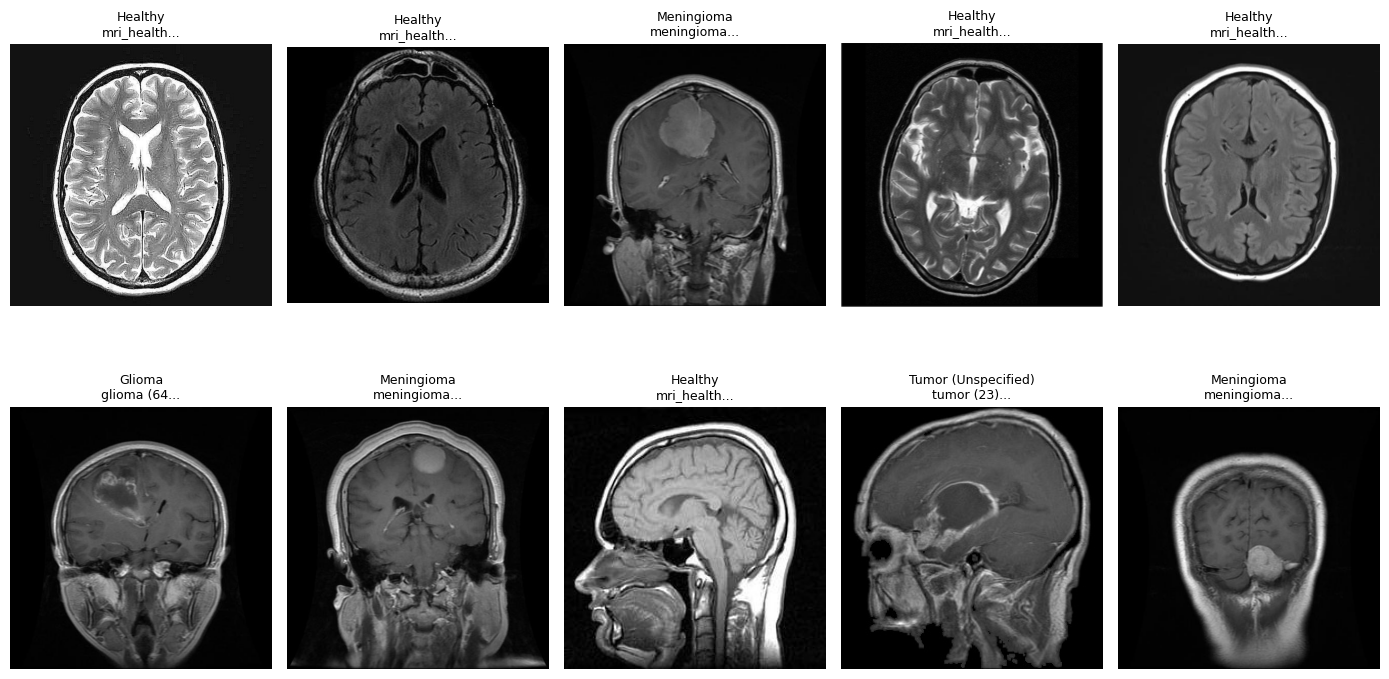

In [3]:
# 2. Split: 80% Train, 20% Test (using stratify to keep classes balanced)
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df['label'])

# 3. Split Train again to get Validation set (e.g. 10% of total)
train_df, val_df = train_test_split(train_df, test_size=0.125, shuffle=True, random_state=42, stratify=train_df['label'])

print(f"Train size: {len(train_df)}")
print(f"Val size:   {len(val_df)}")
print(f"Test size:  {len(test_df)}")

# 4. Visualize to confirm labels are correct

plt.figure(figsize=(14, 8))
# Get a random sample to check
sample_df = df.sample(10)

for i, (index, row) in enumerate(sample_df.iterrows()):
    plt.subplot(2, 5, i + 1)
    img = mpimg.imread(row['filepath'])
    plt.imshow(img, cmap='gray')
    plt.title(f"{row['label']}\n{os.path.basename(row['filepath'])[:10]}...", fontsize=9) # Show label + part of filename
    plt.axis('off')

plt.tight_layout()
plt.show()

***

## 2. Neural Network Models

### 2.1 Custom CNN

The Convolutional Neural Network (CNN) model designed for this project consists of four convolutional blocks followed by a final block with pooling, dropout and fully connected layers. Each convolutional block has a convolution layer, batch normalization, activation function (ReLU) and max pooling. Early stopping was added to control for overfitting and underfitting. Batch normalization was used to improve training speed and stability. Dropout was included in the final block to further prevent overfitting. The model was compiled with the Adam optimizer, categorical cross-entropy loss function, and accuracy as the evaluation metric.

<br>

The architecture is as follows:

**Input and Data Augmentation**
- Input layer: shape (256, 256, 1)
- Data Augmentation: Random rotations and horizontal flips

**First Convolutional Block**
- Conv2d layer: 32 filters, 3x3 kernel, stride of 1, same padding
- Batch Normalization
- ReLU Activation
- MaxPooling2d layer: 2x2 pool size, stride of 2.

**Other Convolutional Blocks**
- same as the first block but with increasing number of filters (64, 128, 256)

**Classifier Head**
- Global Average Pooling layer
- Dense layer: 64 units, ReLU activation
- Dropout layer: 0.3 dropout rate
- Dense layer: 5 units (nº of classes), Softmax activation

In [4]:
### CNN Architecture

# Seed for reproducibility
np.random.seed(42)

# Custom CNN
CNN = keras.Sequential([
    
    # Input
    layers.InputLayer(shape=[256, 256, 1]),
    
    # Data Augmentation
    layers.RandomFlip("horizontal"), # flip images horizontally
    layers.RandomRotation(0.1),      # rotate images randomly by 10%


    # First Convolutional Block
    layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(pool_size=2, strides=2),

    # Second Convolutional Block
    layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(pool_size=2, strides=2),

    # Third Convolutional Block
    layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(pool_size=2, strides=2),

    # Fourth Convolutional Block
    layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(pool_size=2, strides=2),

    # Classifier Head
    layers.GlobalAveragePooling2D(),
    layers.Dense(units=64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(units=5, activation='softmax')  # 5 classes
])

CNN.summary()

Model: "sequential"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├

In [ ]:
### Train and Evaluate CNN

# Compile the model
CNN.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

# Define early stopping
early_stopping = EarlyStopping(
    min_delta = 0.001,
    patience = 20,
    restore_best_weights = True
)

# Fit the model
history = CNN.fit(
    train,
    validation_data = valid,
    batch_size = 32,
    epochs = 25,
    callbacks = [early_stopping],
    verbose = 1
)

### ADD EVALUATION METRICS AND VISUALIZATIONS HERE ###

***

## 2.2 Residual Network
3 ResNet models:
- ResNet from scratch
- ResNet pretrained without finetuning
- ResNet pretrained with finetuning

#### **ResNet from scratch**

#### 1. Preprocessing data
For fast training and less overfitting the inputsize is (128, 128, 1)

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Images to correct format

# 1. Define image size and batch size
IMG_SIZE = (128, 128) 
BATCH_SIZE = 32

# 2. Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

# 3. Build generators FROM DATAFRAMES
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

#### 2. Create ResNet block 

In [ ]:
def resnet_block(x, filters, stride=1):
    shortcut = x

    x = layers.Conv2D(filters, 3, strides=stride, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same")(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

#### 3. Create the model

In [ ]:
def build_resnet(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ])

    x = data_augmentation(inputs)

    x = layers.Conv2D(16, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = resnet_block(x, 16)
    x = resnet_block(x, 16)

    x = resnet_block(x, 32, stride=2)
    x = resnet_block(x, 32)

    x = resnet_block(x, 64, stride=2)
    x = resnet_block(x, 64)

    # x = resnet_block(x, 128, stride=2)
    # x = resnet_block(x, 128)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

In [ ]:
num_classes=5

model_rn_scratch = build_resnet(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1),
    num_classes=num_classes
)

#### 4. Train the model

In [ ]:
# Define early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta = 0.001,
    patience = 20,
    restore_best_weights = True
)

# Checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='best_ResNet.keras',    # Naming the file
    monitor='val_accuracy',       # What to monitor
    mode='max',                   # 'max' for accuracy, 'min' for loss
    save_best_only=True,          
    verbose=0                     # Print a message when saving
)

# Reduce learning rate when needed
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    
    factor=0.5,            # multiply learning rate with 0.5 if there is no enhancement
    patience=3,            
    verbose=1,            
    min_lr=1e-6            
)

In [ ]:
## Compile model
model_rn_scratch.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

## Train model
timer_callback_rn_scratch = ConvergenceTimer()

history = model_rn_scratch.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

#### 4. Visualize the performance on the validation set

In [ ]:
history_frame = pd.DataFrame(history_rn_scratch.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

#### 5. Evaluate model on the test set

In [ ]:
_, accuracy_rn_scratch = model_rn_scratch.evaluate(test_rn_scratch)

#### **Pretrained ResNet without finetuning**


#### 1. Preprocessing data
For the pretrained ResNet-50 model the input should be the same as the ImageNet which is: (224, 224, 3). Therefore we make new train, validation and test sets so that it matches the input the pretrained model expects.

In [ ]:
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_rn_pretrained_ = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_rn_pretrained_ = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_rn_pretrained_ = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_rn_pretrained = train_rn_pretrained_.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_rn_pretrained = val_rn_pretrained_.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_rn_pretrained = test_rn_pretrained_.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


#### 2. Create the model

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

## pretrained base
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False   # Freeze weights

## attach head
model_rn_pt = models.Sequential([

    layers.RandomFlip("horizontal"), # data augmentation
    layers.RandomRotation(0.1),

    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(5, activation='softmax')
])

#### 3. Train the model

In [ ]:
from tensorflow.keras.optimizers import Adam

## Compile model
model_rn_pt.compile(
    optimizer=Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Train model
timer_callback_rn_pt = ConvergenceTimer() # keep track of training time

history_rn_pt = model_rn_pt.fit(
    train_rn_pretrained,
    validation_data=val_rn_pretrained,
    epochs=25,
    callbacks=[checkpoint, early_stopping]
)

#### 4. Visualizing the loss and accuracy for the validation set

In [ ]:
import pandas as pd
history_frame = pd.DataFrame(history_rn_pt.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

#### 5. Evaluating the model on the test set

In [ ]:
_, accuracy_rn_pt = model_rn_pt.evaluate(test_rn_pretrained)

#### **ResNet with finetuning**

#### 1. Create the model with fine tuning
Here we unfreeze the last 37 of 177 layers of the ResNet50 so that the weights of these layers can be trained. The first 140 layers stay froozen (untrained).

In [ ]:
# Unfreeze the model
base_model.trainable = True

# Freeze the first 140 layers "freeze"
for layer in base_model.layers[:140]:
    layer.trainable = False

## attach head
model_rn_pt_finetuned = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(5, activation='softmax')
])

#### 2. Train the model

In [ ]:
## Compile model
model_rn_pt_finetuned.compile(
    optimizer=Adam(1e-5),    
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Train model
timer_callback_rn_pt_finetuned = ConvergenceTimer()

history_rn_pt_finetuned = model_rn_pt_finetuned.fit(
    train_rn_pretrained,
    validation_data=val_rn_pretrained,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)

#### 3. Visualize the performance after fine tuning for the validation set

In [ ]:
import pandas as pd
history_frame = pd.DataFrame(history_rn_pt_finetuned.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

#### 4. Evaluate the model on the test set

In [ ]:
_, accuracy_rn_pt_finetuned = model_rn_pt_finetuned.evaluate(test_rn_pretrained)

***

## 2.3 Pre-trained Vision Transformer
Jiazhen

In [ ]:
# 1. Ensure we know the number of classes (should be 5)
num_classes = len(train_generator.class_indices)

# 2. Load the ViT Base Model (86M Parameters)
model_id = "google/vit-base-patch16-224"

model = TFAutoModelForImageClassification.from_pretrained(
    model_id, 
    num_labels=num_classes, 
    ignore_mismatched_sizes=True
)

# 3. Define Optimizer and Loss (Using tf_keras to avoid version errors)
# ViT requires a small learning rate (5e-5)
optimizer = Adam(learning_rate=5e-5)
loss = CategoricalCrossentropy(from_logits=True)

# 4. Compile the model
# jit_compile=True will help speed up this heavy model on the GPU
model.compile(
    optimizer=optimizer, 
    loss=loss, 
    metrics=['accuracy'],
    jit_compile=True 
)

print(f"Successfully loaded and compiled {model_id}")

In [ ]:
# 1. Setup Generators with 'channels_first'
# We add data_format='channels_first' to match the Hugging Face ViT requirements
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    zoom_range=0.1,
    data_format='channels_first'  # <--- THIS IS THE KEY FIX
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    data_format='channels_first'  # <--- THIS IS THE KEY FIX
)

# 2. Flow from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print("Generators recreated with Channels First format.")

# 3. Now run the training code again

early_stopping = tf_keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=10, 
    validation_data=val_generator,
    callbacks=[early_stopping]
)


In [ ]:
# 1. Load the Backbone 
backbone = TFViTModel.from_pretrained("google/vit-base-patch16-224")
backbone.trainable = True 

# 2. Create Input (Channels First)
inputs = Input(shape=(3, 224, 224), name="input_image")

# 3. Backbone Inference
x = backbone(inputs).last_hidden_state
x = x[:, 0, :] # Extract CLS Token

# 4. Custom Hidden Layers
x = layers.Dense(512, activation='relu', name="hidden_layer_1")(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(256, activation='relu', name="hidden_layer_2")(x)
x = layers.Dropout(0.2)(x)

# 5. Output Layer
outputs = layers.Dense(num_classes, name="prediction_head")(x)

# ---------------------------------------------------------
# CHANGE IS HERE: distinct variable name and model name
# ---------------------------------------------------------
fine_tuned_model = Model(inputs=inputs, outputs=outputs, name="ViT_With_Custom_Head")

# 6. Compile
optimizer = Adam(learning_rate=1e-4)
loss = CategoricalCrossentropy(from_logits=True)

fine_tuned_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Verify the name in the summary
fine_tuned_model.summary()

In [ ]:
history_custom = fine_tuned_model.fit(
    train_generator,
    epochs=10, 
    validation_data=val_generator,
    callbacks=[early_stopping]
)